In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
import os
print("LD_LIBRARY_PATH:", os.environ.get('LD_LIBRARY_PATH'))


LD_LIBRARY_PATH: /usr/local/cuda/lib64:


In [3]:
import tensorflow as tf
print("GPUs detected:", tf.config.list_physical_devices('GPU'))


2025-06-09 22:11:16.680757: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 22:11:16.691492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749525076.703957  159122 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749525076.707538  159122 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749525076.716684  159122 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow import keras
from tensorflow.keras import layers, models #type: ignore
from tensorflow.keras.applications import ResNet50  #type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator #type: ignore
from tensorflow.keras.utils import to_categorical #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.optimizers.schedules import ExponentialDecay #type: ignore
from tensorflow.keras.regularizers import l2 #type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #type: ignore
from tensorflow.keras.metrics import AUC, Precision, Recall #type: ignore

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class ImageDataset:
    def __init__(self, data_dir, max_images_per_class=1500):
        self.data_dir = data_dir
        self.max_images_per_class = max_images_per_class 
        self.images = []
        self.labels = []
        self.class_names = ['hojas', 'otros', 'animales'] 
        
    def load_data(self):
        """Carga datos con validación mejorada y límite de imágenes"""
        total_images = 0
        class_counts = {}
        
        for idx, label in enumerate(self.class_names):
            label_dir = os.path.join(self.data_dir, label)
            if not os.path.exists(label_dir):
                print(f"Advertencia: no existe la carpeta {label_dir}")
                continue
                
            class_count = 0
            for image_name in os.listdir(label_dir):
                if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    continue
                    
                img_path = os.path.join(label_dir, image_name)
                img_array = self.load_and_preprocess_image(img_path)
                if img_array is not None:
                    self.images.append(img_array)
                    self.labels.append(idx)
                    class_count += 1
                    total_images += 1

                if class_count >= self.max_images_per_class:
                    print(f"Clase '{label}': Se han cargado el máximo de {self.max_images_per_class} imágenes.")
                    break
            
            class_counts[label] = class_count
            print(f"Clase '{label}': {class_count} imágenes")
        
        print(f"Total de imágenes cargadas: {total_images}")
        
        if class_counts:
            max_count = max(class_counts.values())
            min_count = min(class_counts.values())
            ratio = max_count / min_count if min_count > 0 else float('inf')
            
            if ratio > 3:
                print(f"Desbalance detectado: ratio {ratio:.2f}:1")
                print("Considera usar class_weight o data augmentation")
        
        return class_counts

    def load_and_preprocess_image(self, img_path):
        """Carga y preprocesa imagen con manejo de errores mejorado"""
        try:
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            return img_array
        except Exception as e:
            print(f"Error al cargar {img_path}: {e}")
            return None


In [ ]:
print("Clasificador de Hojas")
print("=" * 50)

data_dir = 'data/'
dataset = ImageDataset(data_dir)
class_counts = dataset.load_data()

if not dataset.images:
    print("No se cargaron imágenes. Verifica la estructura de carpetas.")
    exit(1)





Clasificador de Hojas
📊 Clase 'hojas': Se han cargado el máximo de 1500 imágenes.
📊 Clase 'hojas': 1500 imágenes
📊 Clase 'otros': Se han cargado el máximo de 1500 imágenes.
📊 Clase 'otros': 1500 imágenes
📊 Clase 'animales': Se han cargado el máximo de 1500 imágenes.
📊 Clase 'animales': 1500 imágenes
📈 Total de imágenes cargadas: 4500


In [ ]:
images = np.array(dataset.images)
labels = np.array(dataset.labels)
labels_cat = to_categorical(labels, num_classes=3)

print(f"\nDatos preparados:")
print(f"Imágenes: {images.shape}")
print(f"Etiquetas: {labels_cat.shape}")


📊 Datos preparados:
   Imágenes: (4500, 224, 224, 3)
   Etiquetas: (4500, 3)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
        images, labels_cat, 
        test_size=0.2, 
        random_state=42, 
        stratify=labels
    )

print(f"\nDivisión de datos:")
print(f"Entrenamiento: {X_train.shape[0]} imágenes")
print(f"Validación: {X_val.shape[0]} imágenes")


🔄 División de datos:
   Entrenamiento: 3600 imágenes
   Validación: 900 imágenes


In [10]:
# Importaciones necesarias
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, TensorBoard
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import (
    Precision, Recall, AUC, F1Score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

In [ ]:
def modelo_base():
    """
    Crea y configura el modelo convolucional para clasificación de hojas.
    """
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,  
        weights='imagenet' 
    )

    base_model.trainable = True

    print(f"Número de capas en el modelo base: {len(base_model.layers)}")

    fine_tune_at = 120 
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    print(f"Capas de la 1 a la {fine_tune_at} congeladas.")
    print(f"Capas de la {fine_tune_at} en adelante listas para fine-tuning.")

    inputs = base_model.input 
    x = base_model.output 
    x = layers.GlobalAveragePooling2D()(x) 
    x = layers.Dropout(0.3)(x) 
    outputs = layers.Dense(3, activation='softmax')(x) 
    modelo_tl = Model(inputs=inputs, outputs=outputs)

    modelo_tl.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall(), AUC()]
    )

    modelo_tl.summary() 
    
    return modelo_tl

modelo = modelo_base()

I0000 00:00:1749525108.874007  159122 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Número de capas en el modelo base: 154
Capas de la 1 a la 120 congeladas.
Capas de la 120 en adelante listas para fine-tuning.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 1,628,739 (6.21 MB)

 Non-trainable params: 633,088 (2.42 MB)

In [ ]:
def configurar_callbacks():
    """
    Configura los callbacks para el entrenamiento.
    """
    callbacks = [
        EarlyStopping(
            patience=3,
            min_delta=0.001,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            filepath='mejor_modelo.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
    
    return callbacks

callbacks = configurar_callbacks()

In [13]:
def entrenar_modelo_con_dataset(modelo, X_train, y_train, X_val, y_val, callbacks, batch_size, epochs):
    """
    Entrena el modelo usando los pipelines de tf.data.
    """
    history = modelo.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=callbacks,
        batch_size=batch_size,
        verbose=1
    )
    return history


In [14]:
history = entrenar_modelo_con_dataset(
    modelo, 
    X_train, y_train, X_val, y_val,
    callbacks, 
    batch_size=16,
    epochs=20
)

Epoch 1/20


I0000 00:00:1749525117.802516  159334 service.cc:152] XLA service 0x78d720001e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749525117.802543  159334 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-09 22:11:57.915778: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749525118.644156  159334 cuda_dnn.cc:529] Loaded cuDNN version 91001
2025-06-09 22:12:08.044854: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-09 22:12:08.251886: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup e

223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5928 - auc: 0.7644 - loss: 0.8975 - precision: 0.6362 - recall: 0.4981

2025-06-09 22:12:18.909800: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1237', 84 bytes spill stores, 84 bytes spill loads

2025-06-09 22:12:19.226600: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1237', 1604 bytes spill stores, 1604 bytes spill loads

2025-06-09 22:12:23.030498: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1237', 120 bytes spill stores, 120 bytes spill loads

2025-06-09 22:12:23.341955: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1237', 1544 bytes spill stores, 1544 bytes spill loads

2025-06-09 22:12:30.355115: E 

225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.5948 - auc: 0.7662 - loss: 0.8939 - precision: 0.6383 - recall: 0.5004 - val_accuracy: 0.8700 - val_auc: 0.9654 - val_loss: 0.3682 - val_precision: 0.8990 - val_recall: 0.8311 - learning_rate: 1.0000e-05
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9123 - auc: 0.9844 - loss: 0.2625 - precision: 0.9289 - recall: 0.8987

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9124 - auc: 0.9844 - loss: 0.2623 - precision: 0.9290 - recall: 0.8988 - val_accuracy: 0.9344 - val_auc: 0.9891 - val_loss: 0.2007 - val_precision: 0.9443 - val_recall: 0.9233 - learning_rate: 1.0000e-05
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9560 - auc: 0.9957 - loss: 0.1468 - precision: 0.9646 - recall: 0.9498

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9561 - auc: 0.9957 - loss: 0.1468 - precision: 0.9646 - recall: 0.9498 - val_accuracy: 0.9622 - val_auc: 0.9951 - val_loss: 0.1264 - val_precision: 0.9673 - val_recall: 0.9533 - learning_rate: 1.0000e-05
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9658 - auc: 0.9968 - loss: 0.1172 - precision: 0.9697 - recall: 0.9604

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9659 - auc: 0.9968 - loss: 0.1171 - precision: 0.9697 - recall: 0.9604 - val_accuracy: 0.9733 - val_auc: 0.9978 - val_loss: 0.0876 - val_precision: 0.9766 - val_recall: 0.9733 - learning_rate: 1.0000e-05
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9805 - auc: 0.9988 - loss: 0.0743 - precision: 0.9825 - recall: 0.9795

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9805 - auc: 0.9988 - loss: 0.0743 - precision: 0.9825 - recall: 0.9794 - val_accuracy: 0.9778 - val_auc: 0.9986 - val_loss: 0.0675 - val_precision: 0.9799 - val_recall: 0.9756 - learning_rate: 1.0000e-05
Epoch 6/20
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9842 - auc: 0.9992 - loss: 0.0588 - precision: 0.9863 - recall: 0.9827

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9842 - auc: 0.9992 - loss: 0.0589 - precision: 0.9863 - recall: 0.9827 - val_accuracy: 0.9844 - val_auc: 0.9991 - val_loss: 0.0528 - val_precision: 0.9877 - val_recall: 0.9822 - learning_rate: 1.0000e-05
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9871 - auc: 0.9994 - loss: 0.0554 - precision: 0.9880 - recall: 0.9828

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9871 - auc: 0.9994 - loss: 0.0554 - precision: 0.9881 - recall: 0.9828 - val_accuracy: 0.9867 - val_auc: 0.9992 - val_loss: 0.0462 - val_precision: 0.9878 - val_recall: 0.9856 - learning_rate: 1.0000e-05
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9848 - auc: 0.9995 - loss: 0.0489 - precision: 0.9859 - recall: 0.9836

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9848 - auc: 0.9995 - loss: 0.0488 - precision: 0.9859 - recall: 0.9836 - val_accuracy: 0.9878 - val_auc: 0.9994 - val_loss: 0.0405 - val_precision: 0.9889 - val_recall: 0.9878 - learning_rate: 1.0000e-05
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9836 - auc: 0.9988 - loss: 0.0527 - precision: 0.9851 - recall: 0.9811

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9836 - auc: 0.9988 - loss: 0.0526 - precision: 0.9851 - recall: 0.9811 - val_accuracy: 0.9889 - val_auc: 0.9996 - val_loss: 0.0356 - val_precision: 0.9889 - val_recall: 0.9878 - learning_rate: 1.0000e-05
Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9905 - auc: 0.9998 - loss: 0.0326 - precision: 0.9921 - recall: 0.9897

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9905 - auc: 0.9998 - loss: 0.0326 - precision: 0.9921 - recall: 0.9897 - val_accuracy: 0.9900 - val_auc: 0.9997 - val_loss: 0.0328 - val_precision: 0.9911 - val_recall: 0.9889 - learning_rate: 1.0000e-05
Epoch 11/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9910 - auc: 0.9997 - loss: 0.0354 - precision: 0.9914 - recall: 0.9907

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9910 - auc: 0.9997 - loss: 0.0354 - precision: 0.9914 - recall: 0.9907 - val_accuracy: 0.9911 - val_auc: 0.9998 - val_loss: 0.0280 - val_precision: 0.9911 - val_recall: 0.9900 - learning_rate: 1.0000e-05
Epoch 12/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9942 - auc: 0.9999 - loss: 0.0250 - precision: 0.9942 - recall: 0.9939 - val_accuracy: 0.9900 - val_auc: 0.9997 - val_loss: 0.0308 - val_precision: 0.9900 - val_recall: 0.9900 - learning_rate: 1.0000e-05
Epoch 13/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9918 - auc: 0.9998 - loss: 0.0277 - precision: 0.9919 - recall: 0.9918 - val_accuracy: 0.9900 - val_auc: 0.9989 - val_loss: 0.0319 - val_precision: 0.9900 - val_recall: 0.9889 - learning_rate: 1.0000e-05
Epoch 14/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9943 - auc: 0.9999 - loss: 0.0217 - precision: 0.9943 - recall: 0.9940 - val_accuracy: 0.9900 - val_auc: 0.9996 - val_loss: 0.03

In [ ]:
def evaluar_modelo(modelo, X_val, y_val):
    """
    Evalúa el modelo con métricas detalladas.
    """

    y_pred = modelo.predict(X_val)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_true_class = np.argmax(y_val, axis=1)
    
    metrics = {}
    for i in range(3):
        y_pred_i = (y_pred_class == i)
        y_true_i = (y_true_class == i)
        
        metrics[f'clase_{i}'] = {
            'precision': precision_score(y_true_i, y_pred_i),
            'recall': recall_score(y_true_i, y_pred_i),
            'f1': f1_score(y_true_i, y_pred_i),
            'auc': roc_auc_score(y_true_i, y_pred_i)
        }
    
    metrics['general'] = {
        'accuracy': accuracy_score(y_true_class, y_pred_class),
        'macro_f1': f1_score(y_true_class, y_pred_class, average='macro'),
        'macro_precision': precision_score(y_true_class, y_pred_class, average='macro'),
        'macro_recall': recall_score(y_true_class, y_pred_class, average='macro')
    }
    
    return metrics

metrics = evaluar_modelo(modelo, X_val, y_val)

2025-06-09 22:13:31.951759: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1148', 212 bytes spill stores, 212 bytes spill loads

2025-06-09 22:13:32.000654: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1148', 84 bytes spill stores, 84 bytes spill loads

2025-06-09 22:13:32.376687: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1148', 1604 bytes spill stores, 1604 bytes spill loads

2025-06-09 22:13:33.006637: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1148', 6096 bytes spill stores, 6052 bytes spill loads

2025-06-09 22:13:41.429165: E 

29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step


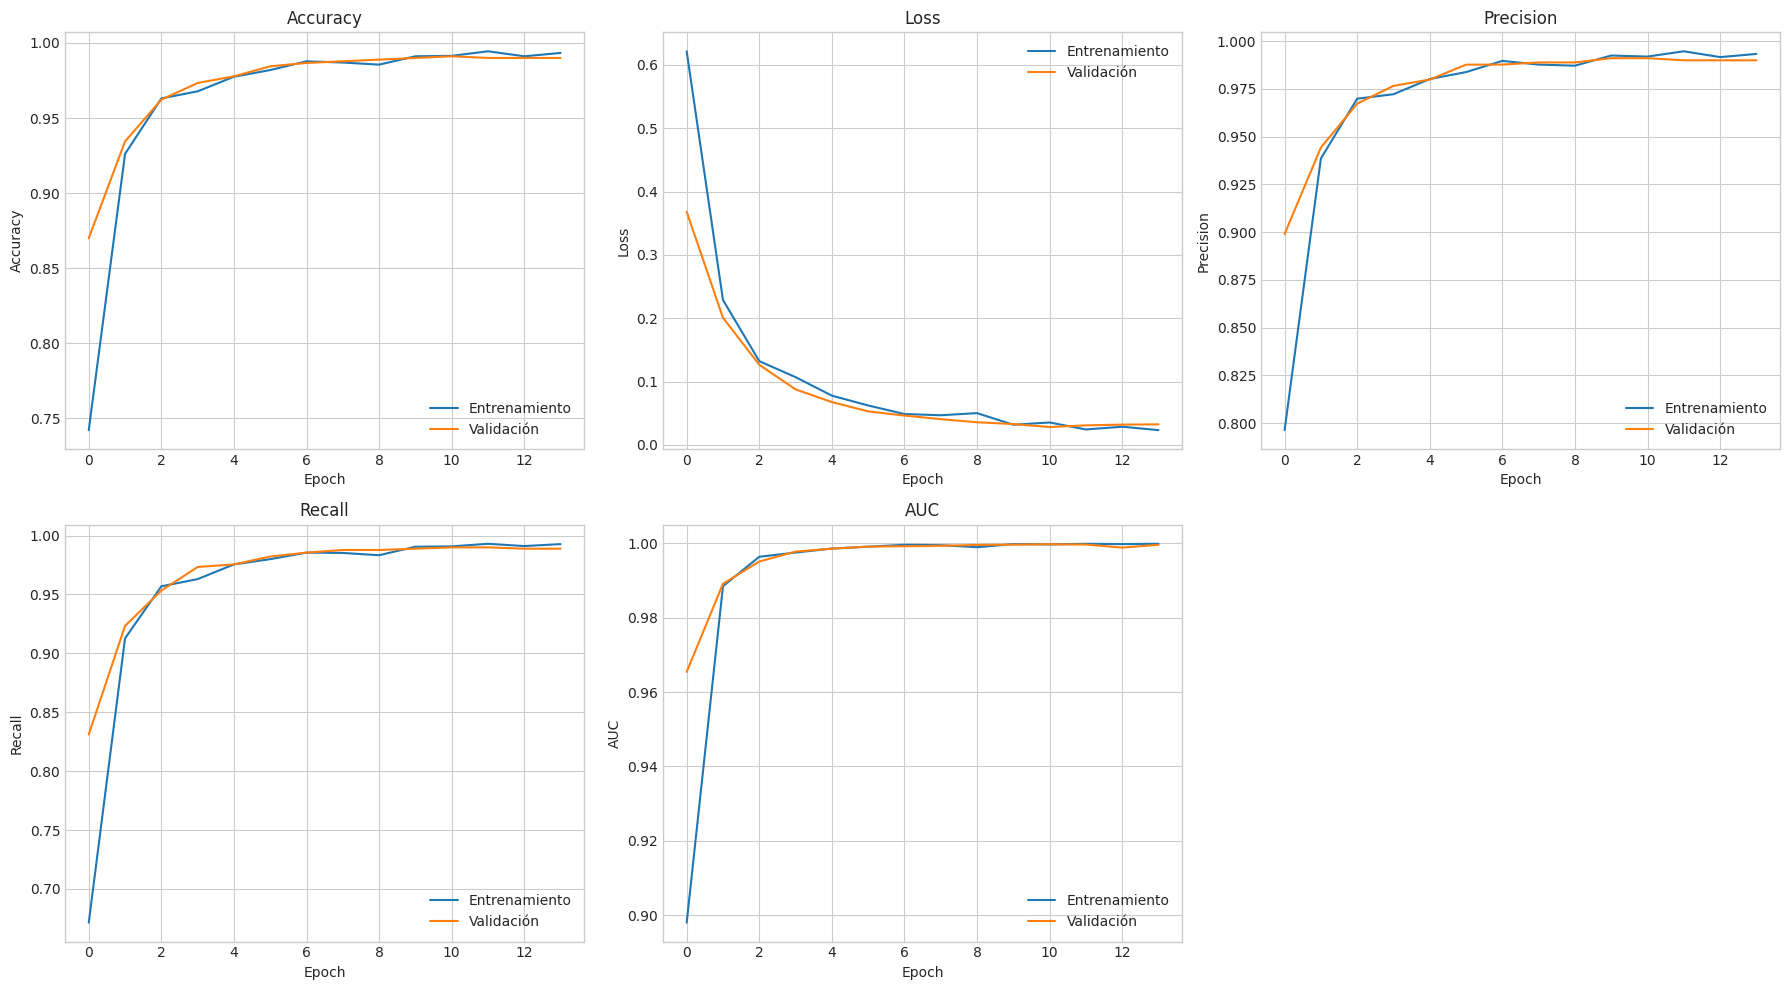

In [ ]:

def visualizar_resultados(history):
    """
    Visualiza las métricas de entrenamiento.
    """
    acc_key = [k for k in history.history.keys() if 'accuracy' in k and 'val' not in k][0]
    val_acc_key = [k for k in history.history.keys() if 'accuracy' in k and 'val' in k][0]
    loss_key = [k for k in history.history.keys() if 'loss' in k and 'val' not in k][0]
    val_loss_key = [k for k in history.history.keys() if 'loss' in k and 'val' in k][0]
    precision_key = [k for k in history.history.keys() if 'precision' in k and 'val' not in k][0]
    val_precision_key = [k for k in history.history.keys() if 'precision' in k and 'val' in k][0]
    recall_key = [k for k in history.history.keys() if 'recall' in k and 'val' not in k][0]
    val_recall_key = [k for k in history.history.keys() if 'recall' in k and 'val' in k][0]
    auc_key = [k for k in history.history.keys() if 'auc' in k and 'val' not in k][0]
    val_auc_key = [k for k in history.history.keys() if 'auc' in k and 'val' in k][0]

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(18, 10))

    plt.subplot(2, 3, 1)
    plt.plot(history.history[acc_key], label='Entrenamiento')
    plt.plot(history.history[val_acc_key], label='Validación')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(history.history[loss_key], label='Entrenamiento')
    plt.plot(history.history[val_loss_key], label='Validación')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 3, 3)
    plt.plot(history.history[precision_key], label='Entrenamiento')
    plt.plot(history.history[val_precision_key], label='Validación')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(history.history[recall_key], label='Entrenamiento')
    plt.plot(history.history[val_recall_key], label='Validación')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(history.history[auc_key], label='Entrenamiento')
    plt.plot(history.history[val_auc_key], label='Validación')
    plt.title('AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

visualizar_resultados(history)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


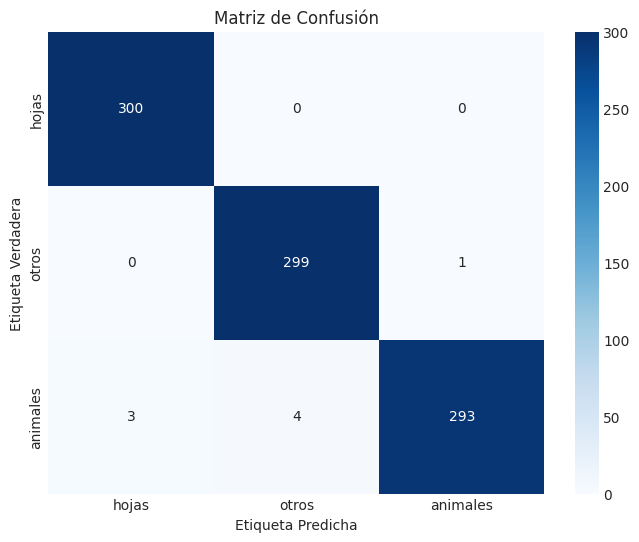

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = modelo.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
class_names = ['hojas', 'otros', 'animales']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()


2025-06-09 22:13:59.749530: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-09 22:13:59.935750: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


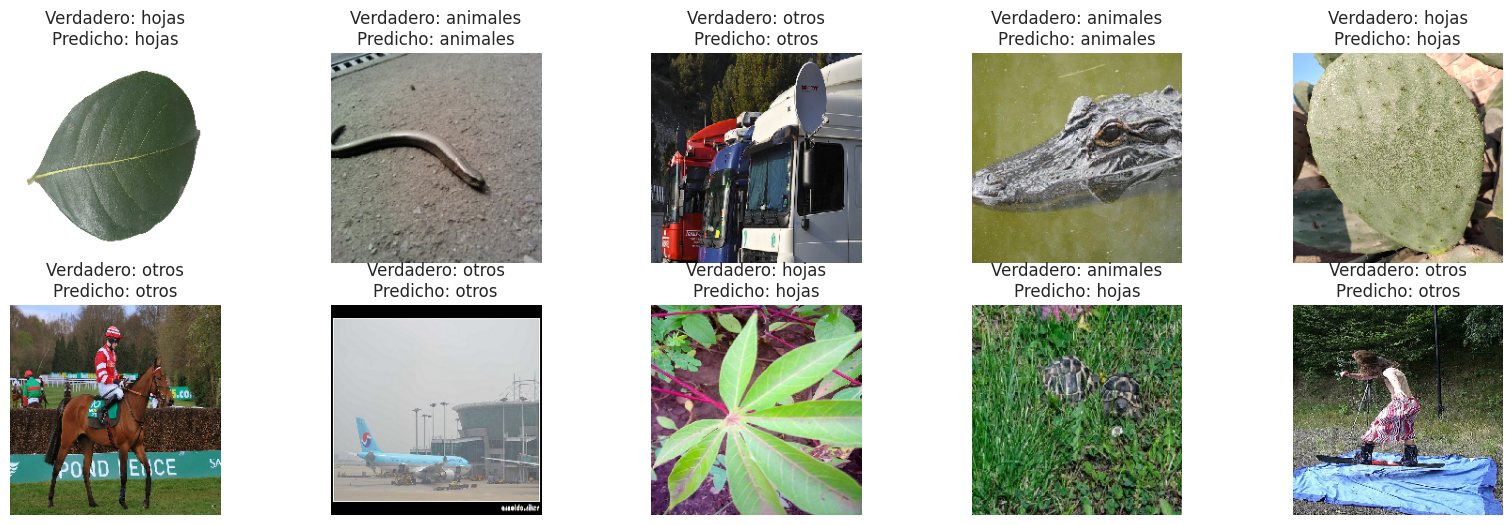

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np


indices = random.sample(range(len(X_val)), 10)

class_names = ['hojas', 'otros', 'animales']

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    img = X_val[idx]
    true_label = np.argmax(y_val[idx])
    
    img_input = np.expand_dims(img, axis=0)
    pred_probs = modelo.predict(img_input)
    pred_label = np.argmax(pred_probs[0])
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Verdadero: {class_names[true_label]}\nPredicho: {class_names[pred_label]}")
    
plt.show()




In [19]:
modelo.save("modelo_hojas_multiclasev3.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


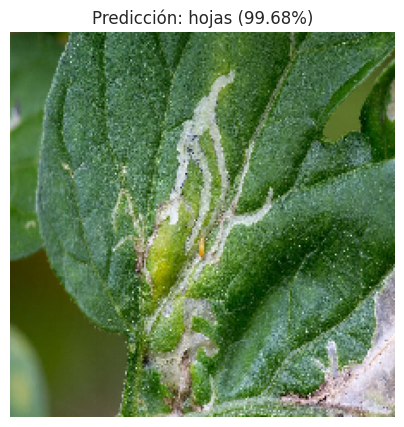

Shape de la imagen procesada: (224, 224, 3)
Predicción cruda (probabilidades): [9.9676526e-01 2.9574972e-04 2.9389476e-03]
Predicción final: hojas con probabilidad 0.9968


In [ ]:
from tensorflow.keras.models import load_model #type: ignore
from tensorflow.keras.preprocessing import image #type: ignore

modelo_cargado = load_model('modelo_hojas_multiclasev3.h5')
img_path = 'tests/csm_tomato_leaf_miner_liriomyza_bryoniae_damage_22_koppert_aaeec9aa5d.jpg'
clases = ['hojas', 'otros', 'animales']

img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

prediccion = modelo_cargado.predict(img_array_expanded)

indice_clase = np.argmax(prediccion[0])

etiqueta_predicha = clases[indice_clase]
probabilidad = prediccion[0][indice_clase]

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicción: {etiqueta_predicha} ({probabilidad:.2%})")
plt.show()

print(f"Shape de la imagen procesada: {img_array.shape}")
print(f"Predicción cruda (probabilidades): {prediccion[0]}")
print(f"Predicción final: {etiqueta_predicha} con probabilidad {probabilidad:.4f}")